In [1]:
import numpy as np
from functools import reduce
from scipy.signal import gaussian
import matplotlib.pyplot as plt
import cv2

In [2]:
def convolution(image, kernel):
    '''Vanilla implementation of convolution'''
    image_shape = np.array(image.shape)
    kernel_shape = np.array(kernel.shape)
    
    height, width = image_shape - kernel_shape + 1
    
    output = np.zeros((height, width))
    
    for i in range(height):
        for j in range(width): 
            
            output[i][j] = np.sum(image[i:i+kernel_shape[0], j:j+kernel_shape[1]] * kernel)
            
    return output

def gaussian_blur(image, kernel_size, sigma):
    '''Compute gaussian square kernel using the tensor 
    product of two independent distributions'''
    kernel = gaussian(kernel_size, std=sigma).reshape(kernel_size, 1)
    kernel = np.outer(kernel, kernel)
    
    output = convolution(image, kernel)
    
    return output

def normalization(image):
    '''Image normalization to range 0 ... 255'''
    image = image + np.abs(image.min())
    image = image / image.max()
    image = image * 255
    image = image.astype(np.uint8)
    
    return image

In [3]:
def get_circle(row, col):
    '''Get circle of 16 points around chosen keypoint'''
    point1 = (row-3, col)
    point2 = (row-3, col+1)
    
    point3 = (row-2, col+2)
    
    point4 = (row-1, col+3)
    point5 = (row, col+3)
    point6 = (row+1, col+3)
    
    point7 = (row+2, col+2)
    
    point8 = (row+3, col+1)
    point9 = (row+3, col)
    point10 = (row+3, col-1)
    
    point11 = (row+2, col-2)
    
    point12 = (row+1, col-3)
    point13 = (row, col-3)
    point14 = (row-1, col-3)
    
    point15 = (row-2, col-2)
    
    point16 = (row-3, col-1)
    
    l = [point1, point2, point3, point4, point5, point6, point7, point8,
         point9, point10, point11, point12, point13, point14, point15, point16]
    
    return l

def get_contiguous_roi(roi):
    '''Get the list of contiguous region of interest 
    For example, [0,  1, 2, 6, 7] -> [[0, 1, 2], [6, 7]]'''
    output = []
    output.append([roi[0]])
    for element in roi[1:]:
        if abs(element - output[-1][-1]) <= 1:
            output[-1].append(element)
        else:
            output.append([element])
    return output

def high_speed_test(image, row, col, roi, threshold):
    '''FAST high speed test'''
    intensity = int(image[row][col])
    
    row1, col1 = roi[0]
    row5, col5 = roi[4]
    row9, col9 = roi[8]
    row13, col13 = roi[12]
    
    intensity1 = int(image[row1][col1])
    intensity5 = int(image[row5][col5])
    intensity9 = int(image[row9][col9])
    intensity13 = int(image[row13][col13])
    
    count = 0
    if abs(intensity1 - intensity) > threshold:
        count += 1 
    if abs(intensity9 - intensity) > threshold:
        count += 1
    if abs(intensity5 - intensity) > threshold:
        count += 1
    if abs(intensity13 - intensity) > threshold:
        count += 1
        
    return count >= 3

def full_test(image, row, col, roi, threshold, n=12):
    '''FAST full test'''
    intensity = int(image[row][col])
    
    indexes = []
    
    for i, element in enumerate(roi):
        
        x, y = element
        intenstity_second = image[x][y]
        if abs(intensity - intenstity_second) > threshold:
            indexes.append(i)
    
    indexes = get_contiguous_roi(indexes)
    
    #compute the max size of contiguous region
    max_size = reduce(lambda x, y: max(x, len(y)), indexes, 0)
    if max(indexes[-1]) == 15 and min(indexes[0]) == 0:
        max_size = max(max_size, len(indexes[-1]) + len(indexes[0]))
    
    return max_size >= n

def calculate_score(image, point, roi):
    '''Calculate score of the keypoint (will use it in non-maximum suppresion as metric)'''
    row, col = point
    intensity = image[row][col]
    
    score = sum(list(map(lambda x: abs(image[x[0]][x[1]] - intensity), roi)))
    
    return score

def points_is_near(point_x, point_y, radius=6):
    '''Check if points are near by the given radius'''
    row1, col1 = point_x
    row2, col2 = point_y
    
    x_delta = row1 - row2
    y_delta = col1 - col2
    distance = (x_delta ** 2 + y_delta ** 2) ** 0.5 
    
    return distance <= radius

def suppress(image, corners):
    '''Algorithm of non-maximum suppression'''
    i = 1
    while i < len(corners):
        
        curr_point = corners[i]
        prev_point = corners[i-1]
        
        if points_is_near(prev_point, curr_point):
            
            roi_curr = get_circle(curr_point[0], curr_point[1])
            roi_prev = get_circle(prev_point[0], prev_point[1])
            
            curr_score = calculate_score(image, curr_point, roi_curr)
            prev_score = calculate_score(image, prev_point, roi_prev)
            
            if (curr_score > prev_score):
                del(corners[i-1])
            else:
                del(corners[i])
                
        else:
            i += 1
            continue
            
    return corners

def fast_detector(image, threshold=10):
    '''FAST detector pipeline'''
    indexes_x = np.arange(0, image.shape[0], dtype=int)
    indexes_y = np.arange(0, image.shape[1], dtype=int)
    
    corners = []
    for index_x in indexes_x[3:-3]:
        for index_y in indexes_y[3:-3]:
            
            roi = get_circle(index_x, index_y)
            if high_speed_test(image, index_x, index_y, roi, threshold):
                if full_test(image, index_x, index_y, roi, threshold):
                    corners.append((index_x, index_y))
    corners = suppress(image, corners)
    
    return corners

In [4]:
def generate_strategy(n_size, patch_size, random_seed=42):
    '''Generate strategy of BRIEF descriptor main points. 
    X, Y sampled from uniform discribution in the patch.'''
    np.random.seed(random_seed)
    
    x_1 = np.random.randint(low=0, high=patch_size, size=n_size)
    y_1 = np.random.randint(low=0, high=patch_size, size=n_size)
    
    x_2 = np.random.randint(low=0, high=patch_size, size=n_size)
    y_2 = np.random.randint(low=0, high=patch_size, size=n_size)
    
    return np.vstack((x_1, y_1)).T, np.vstack((x_2, y_2)).T

def get_patch(point, image, patch_size):
    '''Get patch around the keypoint'''
    x_index, y_index = point
    bias = patch_size // 2
    
    patch = image[x_index-bias:x_index+bias, 
                  y_index-bias:y_index+bias]
    
    return patch

def get_desctiptor(patch, sampling_strategy):
    '''Get descriptor of the patch by computing
    the condition Image(X) < Image(Y)'''
    output = []

    for x, y in zip(*sampling_strategy):
        
        output.append(patch[tuple(x)] < patch[tuple(y)])
        
    output = np.array(output, dtype=int)
    
    return output

def is_border_keypoint(point, image, patch_size):
    '''Check if point can have patch around itself'''
    x_index, y_index = point
    bias = patch_size // 2
    
    border_condition_x = x_index < bias or x_index > image.shape[0] - bias
    border_condition_y = y_index < bias or y_index > image.shape[1] - bias
    
    border_condition = border_condition_x or border_condition_y
    
    return border_condition

def brief(image, keypoints, patch_size=48, feature_size=8*32):
    '''BRIEF descriptor pipeline'''
    strategy = generate_strategy(feature_size, patch_size)
        
    output = []
    points = []
    for keypoint in keypoints:
        
        point = tuple(map(lambda x: int(x), keypoint))
        
        if not is_border_keypoint(point, image, patch_size):
            
            patch = get_patch(point, image, patch_size)
            descriptor = get_desctiptor(patch, strategy)
        
            output.append(descriptor)
            points.append(keypoint)
        
    output = np.array(output)
    output = to_encoding(output)
    
    return points, output

def to_encoding(des):
    '''Encode binary vector into the vector of bytes represented as integers'''
    shape = (des.shape[0], des.shape[1] // 8)
    des = des.reshape(-1, 8)
    des = np.apply_along_axis(lambda x: int(''.join(x.astype(str)), 2), 1, des)
    des = des.reshape(shape)
    des = des.astype(np.uint8)
    
    return des

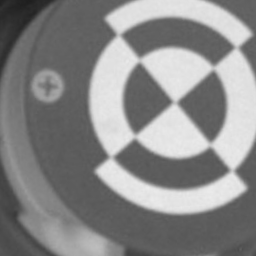

In [209]:
from PIL import Image

image = Image.open('tracking/rotation_5_1.png')
image

In [210]:
filtered_image = gaussian_blur(np.array(image), kernel_size=31, sigma=0.1)
filtered_image = normalization(filtered_image)

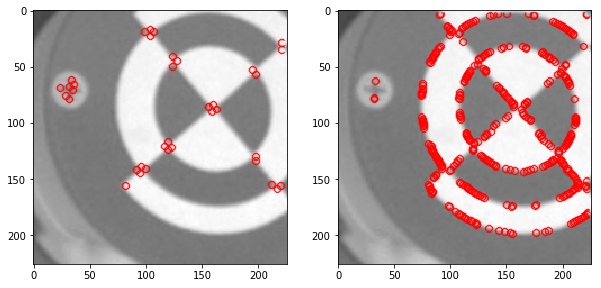

In [242]:
import cv2

fast = cv2.FastFeatureDetector_create()

kp_opencv = fast.detect(filtered_image)

kp_custom = fast_detector(filtered_image.astype(int), threshold=10)
kp = kp_custom
kp_custom = list(map(lambda x: cv2.KeyPoint(x[1], x[0], _size=1), kp_custom))

image_custom = cv2.drawKeypoints(filtered_image, kp_custom, None, color=(255, 0, 0))
image_opencv = cv2.drawKeypoints(filtered_image, kp_opencv, None, color=(255, 0, 0))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axes[0].imshow(image_opencv)
axes[1].imshow(image_custom)

In [262]:
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
kp_custom_2, des = brief.compute(filtered_image, kp_custom)

In [263]:
des

array([[183, 185, 177, ..., 151,  61,   8],
       [228, 248, 199, ..., 168, 179, 210],
       [231, 184, 211, ..., 178,  63, 136],
       ...,
       [ 25,   7,  44, ...,  93, 140, 117],
       [ 25,   6,  44, ..., 120,  76, 255],
       [ 24,   7,  44, ...,  93, 140, 253]], dtype=uint8)

In [5]:
img_in_path = 'tracking/'


def match_brute_force(descr_arr0, descr_arr1):
    bf = cv2.BFMatcher()
    # return 2 matches for keypoint
    matches = bf.knnMatch(descr_arr0, descr_arr1, k=2)

    matches_arr = []
    for match_a, match_b in matches:
        # mark match good if 2nd match has bigger distance
        # (filtering similar keypoints)
        if match_a.distance < 0.75 * match_b.distance:
            matches_arr.append((
                match_a.queryIdx,
                match_a.trainIdx
            ))

    return matches_arr


for test_name in ['translation_', 'translation_noise_', 'rotation_2_', 'rotation_5_']:
    for frame_idx in range(9):
        # read two frames
        img0_fpath = img_in_path + test_name + str(frame_idx) + '.png'
        img0 = cv2.imread(img0_fpath, cv2.IMREAD_GRAYSCALE)

        img1_fpath = img_in_path + test_name + str(frame_idx+1) + '.png'
        img1 = cv2.imread(img1_fpath, cv2.IMREAD_GRAYSCALE)
        
        img0 = gaussian_blur(img0, kernel_size=15, sigma=2)
        img0 = normalization(img0)
        
        img1 = gaussian_blur(img1, kernel_size=15, sigma=2)
        img1 = normalization(img1)
        
        rows = img0.shape[0]
        cols = img0.shape[1]

        # detect keypoints and calculate descriptors
        
        kp0 = fast_detector(img0.copy(), threshold=10)
        #kp0 = list(map(lambda x: cv2.KeyPoint(x[1], x[0], _size=1), kp0))
        kp0, descr0 = brief(img0.copy(), kp0)
        
        kp1 = fast_detector(img1.copy(), threshold=10)
        #kp1 = list(map(lambda x: cv2.KeyPoint(x[1], x[0], _size=1), kp1))
        kp1, descr1 = brief(img1.copy(), kp1)
        
        
        #kp0, descr0 = detect_keypoints_and_calculate_descriptors(img0.copy())
        #kp1, descr1 = detect_keypoints_and_calculate_descriptors(img1.copy())

        # match
        match_arr = match_brute_force(descr0, descr1)

        # draw on one image
        img_both = np.zeros((rows, cols*2), np.uint8)
        img_both[:, 0:cols] = img0.T
        img_both[:, cols:cols*2] = img1.T
        img_both_bgr = cv2.cvtColor(img_both, cv2.COLOR_GRAY2BGR)

        # keypoints as red circles
        for i in range(len(kp0)):
            kp = kp0[i]
            x = kp[0]
            y = kp[1]
            cv2.circle(img_both_bgr, (x, y), 10, (0, 0, 255))

        for i in range(len(kp1)):
            kp = kp1[i]
            x = kp[0] + cols
            y = kp[1]
            cv2.circle(img_both_bgr, (x, y), 10, (0, 0, 255))

        # matches as green lines
        for pair in match_arr:
            x0 = kp0[pair[0]][0]
            y0 = kp0[pair[0]][1]
            x1 = kp1[pair[1]][0] + cols
            y1 = kp1[pair[1]][1]
            cv2.line(img_both_bgr, (x0, y0), (x1, y1), (0, 255, 0))

        # show image and wait for key press
        cv2.imshow('img_both', img_both_bgr)
        cv2.waitKey(-1)

/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: overflow encountered in ubyte_scalars
